In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 여기 코드 실행 후 런타임 재실행 후 모든 실행 부탁드립니다!
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

plt.rc('font', family='NanumBarunGothic')

<br>

## 1. Preparing dataset (2번부터 실습 진행)

In [ ]:
data_df = pd.read_csv('./titanic.csv')
data_df2 = data_df.copy()
data_df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


<br> <br>

## Data info
<br>

- **PassengerId** : A unique Id for each passenger. <br>Each Id takes the form **gggg_pp** where **gggg** indicates **a group the passenger is travelling with** and **pp** is **their number within the group**. <br> People in a group are often family members, but not always.<br><br>  

- **HomePlanet** : The planet the passenger departed from, typically their planet of permanent residence.<br><br>  

- **CryoSleep** : Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. <br> Passengers in cryosleep are confined to their cabins.<br><br>  

- **Cabin** : The cabin number where the passenger is staying. <br> Takes the form **deck/num/side**, where **side** can be either **P for Port** or **S for Starboard**.<br><br>  

- **Destination** : The planet the passenger will be debarking to.<br><br>  

- **Age** : The age of the passenger.<br><br>  

- **VIP** : Whether the passenger has paid for special VIP service during the voyage.<br><br>  

- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** : Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.<br><br>  

- **Name** : The first and last names of the passenger.<br><br>  

- **Transported** : Whether the passenger was transported to another dimension. <br> This is **the target**, the column you are trying to predict.<br><br>  

<br>

## 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기
- 결측치 채우기
- Text로 되어있는 Category는 숫자로 바꿔주기 (ex. True/False -> 1/0)
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
data_df.describe().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [ ]:
data_df.corr().round(2)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.00,0.07,0.13,0.03,0.12,0.10,-0.08
RoomService,0.07,1.00,-0.02,0.05,0.01,-0.02,-0.24
FoodCourt,0.13,-0.02,1.00,-0.01,0.22,0.23,0.05
ShoppingMall,0.03,0.05,-0.01,1.00,0.01,-0.01,0.01
Spa,0.12,0.01,0.22,0.01,1.00,0.15,-0.22
VRDeck,0.10,-0.02,0.23,-0.01,0.15,1.00,-0.21
Transported,-0.08,-0.24,0.05,0.01,-0.22,-0.21,1.00


In [ ]:
data_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
# Cabin 결측치 처리

# 카테고리 널값 Z로 채우기
data_df['Cabin'] = data_df['Cabin'].fillna('Z/9999/Z')

# '/'를 기준으로 'Cabin' 데이터 문자열 분할
split_data = data_df['Cabin'].str.split('/', expand=True)

## 컬럼 이름 변경 deck/num/side
split_data.columns = ['Deck', 'Num', 'Side']

# 분할된 데이터프레임과 원본 데이터프레임 병합
data_df = pd.concat([data_df, split_data], axis=1)

data_df.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [ ]:
# HomePlanet, Destination 결측치 처리

# HomePlanet 데이터 확인
print(data_df.HomePlanet.value_counts() ,'\n')

# Destination 데이터 확인
print(data_df.Destination.value_counts() ,'\n')


Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64 

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64 



<Axes: xlabel='HomePlanet', ylabel='count'>

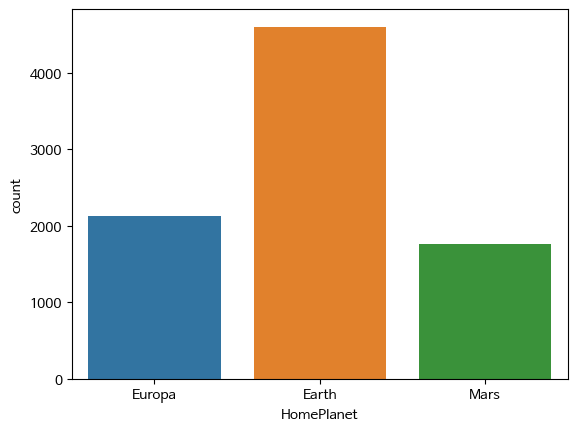

In [ ]:
# HomePlanet 데이터보기
sns.countplot(data=data_df, x='HomePlanet')

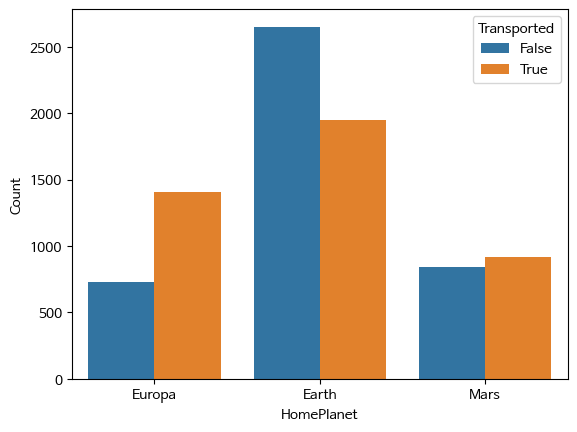

In [ ]:
# HomePlanet와 Transported
sns.countplot(data=data_df, x='HomePlanet' ,hue='Transported')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='Destination', ylabel='count'>

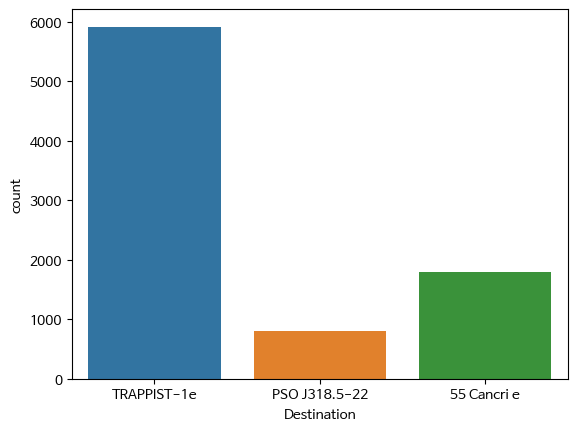

In [ ]:
# Destination 데이터보기
sns.countplot(data=data_df, x='Destination')

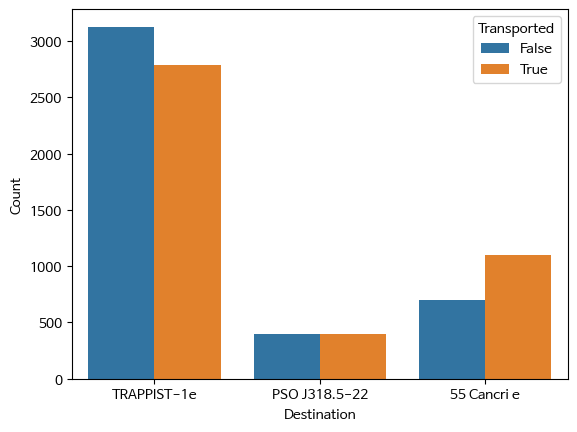

In [ ]:
# Destination과 Transported
sns.countplot(data=data_df, x='Destination' ,hue='Transported')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.show()

In [ ]:
# passengerId gggg_xx => gggg 그룹id 로 변환
data_df['PassengerId'] = data_df['PassengerId'].str.slice(0,4)

# 변환한 id 그룹 데이터가 2개이상인 경우
grouped=data_df.groupby('PassengerId')
grouped_count = grouped.size()
index_list = grouped_count[grouped_count >= 2].index.tolist()
condition= data_df['PassengerId'].isin(index_list)

# 같은그룹인데 출발지가 비어있는경우 92/201
print(data_df[condition][data_df[condition].HomePlanet.isnull()],'\n')
# 같은그룹인데 목적지가 비어있는경우 79/182
print(data_df[condition][data_df[condition].Destination.isnull()])

     PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
59          0064        NaN      True     E/3/S  TRAPPIST-1e  33.0  False   
113         0119        NaN     False     A/0/P  TRAPPIST-1e  39.0  False   
405         0444        NaN     False    F/99/P  TRAPPIST-1e  26.0   True   
407         0445        NaN     False    E/25/S  TRAPPIST-1e  26.0  False   
438         0470        NaN      True    F/86/S  TRAPPIST-1e  36.0  False   
...          ...        ...       ...       ...          ...   ...    ...   
8353        8938        NaN      True  F/1729/S  TRAPPIST-1e  22.0  False   
8383        8961        NaN     False  F/1839/P  TRAPPIST-1e  21.0  False   
8454        9030        NaN     False  G/1465/P  TRAPPIST-1e  27.0  False   
8489        9072        NaN      True  F/1758/S  TRAPPIST-1e  23.0  False   
8613        9194        NaN     False   E/603/S  55 Cancri e  53.0  False   

      RoomService  FoodCourt  ShoppingMall    Spa  VRDeck              Name

In [ ]:
#passengerId가 같은데 homeplanet이 다른경우가 있는지 체크 => 다같음 확인
data_df
passenger_homeplanet={}
for i,row in data_df.iterrows():
    if not pd.isna(row.HomePlanet):
        if row.PassengerId in passenger_homeplanet and row.HomePlanet not in passenger_homeplanet[row.PassengerId]:
            passenger_homeplanet[row.PassengerId].append(row.HomePlanet)
        else:
            passenger_homeplanet[row.PassengerId]=[row.HomePlanet]

result = {key: value for key, value in passenger_homeplanet.items() if len(value) >= 2}
print("homeplanet 다른 경우 =>",result)

homeplanet 다른 경우 => {}


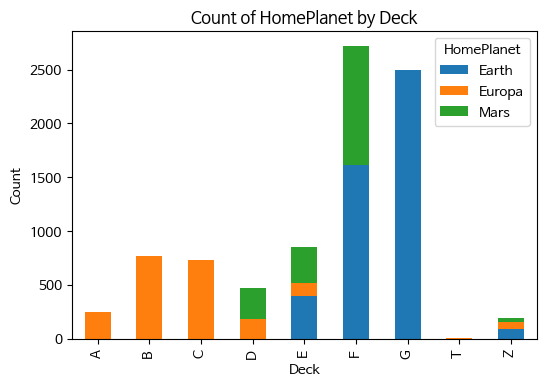

In [ ]:
# Cabin column을 split 한 Deck column 과 HomePlanet 관계
grouped_df = data_df.groupby('Deck').HomePlanet.value_counts().unstack()
grouped_df.plot(kind='bar', stacked=True, figsize=(6,4))
plt.xlabel('Deck')
plt.ylabel('Count')
plt.title('Count of HomePlanet by Deck')
plt.show()

In [ ]:
# homeplanet
# 1순위 slicing 한 같은 groupid의 Homeplanet 채우기
# 2순위 split 한 deck column 과의 관계를 통한 Homeplanet 채우기
# 3순위 homeplanet 최빈값인 Earth 로 채우기

deck_hoemplanet_dict ={'A':'Europa','B':'Europa','C':'Europa','D':'Mars','E':'Earth','F':'Earth','G':'Earth'}
def hoemplanet_pre_processing(df):

    if pd.isna(df.HomePlanet):
        #1순위
        if df.PassengerId in passenger_homeplanet:
            return passenger_homeplanet[df.PassengerId][0]
        #2순위
        elif not pd.isna(df.Cabin) and df.Cabin.split('/')[2] in deck_hoemplanet_dict:
            return deck_hoemplanet_dict[df.Cabin.str.split('/')[2]]
        #3순위
        else :
            return 'Earth'
    else: return df.HomePlanet


data_df['HomePlanet'] = data_df.apply(hoemplanet_pre_processing, axis=1)

In [ ]:
# 같은 그룹인데 목적지가 다른경우는 존재함
data_df[data_df['PassengerId']=='0067']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side
61,0067,Earth,True,G/10/S,PSO J318.5-22,0.0,False,0.0,0.0,0.0,0.0,0.0,Ninaha Leeves,True,G,10,S
62,0067,Earth,False,G/10/S,TRAPPIST-1e,18.0,False,1.0,258.0,446.0,0.0,0.0,Celine Leeves,True,G,10,S
63,0067,Earth,False,F/15/S,55 Cancri e,21.0,False,1946.0,37.0,0.0,0.0,24.0,Velyne Leeves,False,F,15,S


In [ ]:
# 목적지는 최빈값으로 채우기
data_df['Destination'] = data_df.apply(lambda x: 'TRAPPIST-1e' if pd.isna(x.Destination) else x.Destination, axis=1)

False    8291
True      199
Name: VIP, dtype: int64


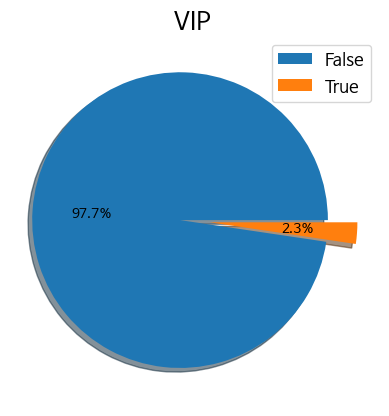

In [ ]:
# VIP 데이터보기
print(data_df.VIP.value_counts())

plt.pie(data_df.VIP.value_counts(), shadow=True, explode=[.1,.1], autopct='%.1f%%')
plt.title('VIP ', size=18)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

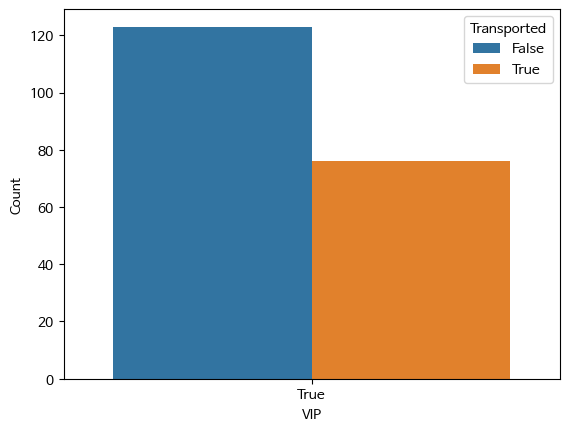

In [ ]:
# Filter the data for VIP where VIP column is True
filtered_data = data_df[data_df['VIP'] == True]

# Plot the count of Transported values for VIP
sns.countplot(data=filtered_data, x='VIP', hue='Transported')
plt.xlabel('VIP')
plt.ylabel('Count')
plt.show()

In [ ]:
# VIP 결측치 최빈값으로 채움
VIP_mode = data_df['VIP'].mode()[0]
data_df['VIP'].fillna(VIP_mode, inplace=True)

In [ ]:
# CryoSleep 결측치처리

# 비용 지불 5개 항목의 결측치를 0으로 입력

data_df.RoomService.fillna(0, inplace=True)
data_df.FoodCourt.fillna(0, inplace=True)
data_df.ShoppingMall.fillna(0, inplace=True)
data_df.Spa.fillna(0, inplace=True)
data_df.VRDeck.fillna(0, inplace=True)
data_df.info()

# ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'] 합계 열 추가

data_df['sum_5'] = data_df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
data_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Deck          8693 non-null   object 
 15  Num           8693 non-null   object 
 16  Side          8693 non-null   object 
dtypes: bool(2), float64(6), object(9)
memory usage: 1.0+ MB


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,sum_5
0,0001,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P,0.0
1,0002,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S,736.0
2,0003,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S,10383.0
3,0003,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S,5176.0
4,0004,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S,1091.0


그룹별 사용금액 평균 CryoSleep
False    2248.299687
True        0.000000
Name: sum_5, dtype: float64 

그룹별 사용금액 최대값 CryoSleep
False    35987.0
True         0.0
Name: sum_5, dtype: float64



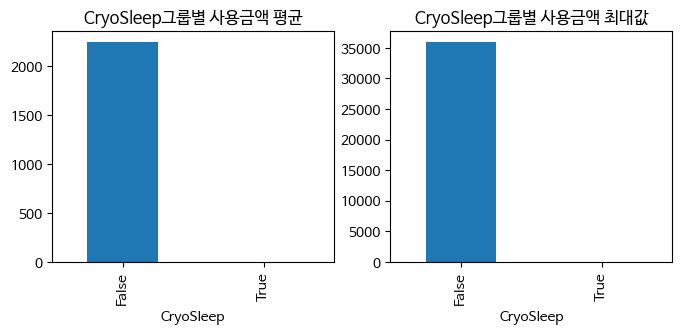

In [ ]:
# CryoSleep값에 따른 비용 지불 시각화 : True일 경우 0
#     -> 비용 지불이 0 일경우 CryoSleep의 결측치 값은 0으로 입력#

import matplotlib as mpl

# CryoSleep 그룹별 사용금액 평균
group_mean = data_df.groupby('CryoSleep')['sum_5'].mean()
print('그룹별 사용금액 평균', group_mean, '\n')
# CryoSleep 그룹별 사용금액 최대값
group_max = data_df.groupby('CryoSleep')['sum_5'].max()
print('그룹별 사용금액 최대값', group_max)

fig, axs = plt.subplots(1,2, figsize=(8,3))
# 'CryoSleep그룹별 사용금액 평균' 그래프
group_mean.plot(kind='bar', ax=axs[0])
axs[0].set_title('CryoSleep그룹별 사용금액 평균')
# 'CryoSleep그룹별 사용금액 최대값' 그래프
group_max.plot(kind='bar', ax=axs[1])
axs[1].set_title('CryoSleep그룹별 사용금액 최대값')

print('')
plt.show()

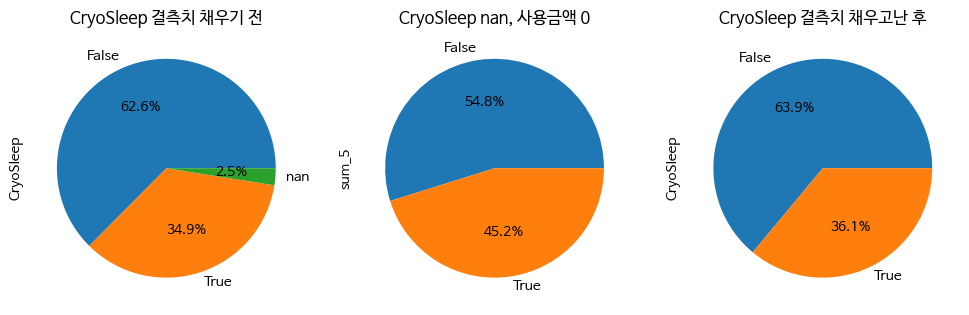

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
# CryoSleep 결측치 채우기 전 비율
sleep_rate = data_df.CryoSleep.value_counts(dropna=False)
sleep_rate.plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_title('CryoSleep 결측치 채우기 전')

# CryoSleep 값이 결측치인 row에서, 사용금액이 0과 0이 아닌 비율
sleep_null_rate = (data_df.loc[data_df.CryoSleep.isnull(), 'sum_5'] == 0).value_counts()
sleep_null_rate.plot(kind='pie', autopct='%1.1f%%', ax=axs[1])
axs[1].set_title('CryoSleep nan, 사용금액 0')

# CryoSleep 값이 결측치인 row에서, 사용금액이 0이면 CryoSleep은 True, 아니면 False 채우기
data_df.loc[(data_df.CryoSleep.isnull()) & (data_df.sum_5==0), 'CryoSleep'] = True
data_df.loc[(data_df.CryoSleep.isnull()) & (data_df.sum_5!=0), 'CryoSleep'] = False

# CryoSleep 열의 결측치를 채우고난 후 비율
sleep_rate = data_df.CryoSleep.value_counts(dropna=False)
sleep_rate.plot(kind='pie', autopct='%1.1f%%', ax=axs[2])
axs[2].set_title('CryoSleep 결측치 채우고난 후')

plt.show()

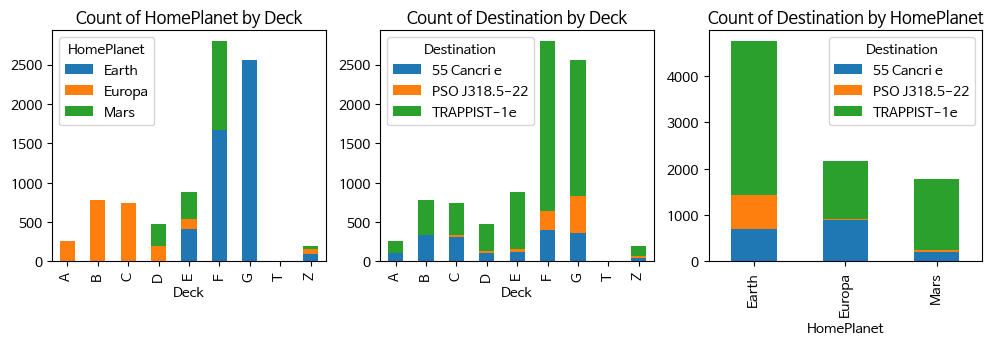

In [ ]:
# '/' 기준으로 Cabin 열 3개로 나누기 ['Deck', 'Num', 'Side']

deck_home_df = data_df.groupby('Deck').HomePlanet.value_counts().unstack()
#print('[Deck와 HomePlanet의 관계]', '\n', deck_home_df)
deck_des_df = data_df.groupby('Deck').Destination.value_counts().unstack()
#print('[Deck와 HomePlanet의 관계]', '\n', deck_des_df)
home_des_df = data_df.groupby('HomePlanet').Destination.value_counts().unstack()
#print('[Home과 Destination의 관계]', '\n', deck_des_df)

fig, axs = plt.subplots(1,3, figsize=(12,3))
# Deck와 HomePlanet의 관계
deck_home_df.plot(kind='bar', stacked=True, ax=axs[0])
axs[0].set_title('Count of HomePlanet by Deck')
# Deck와 Destination의 관계
deck_des_df.plot(kind='bar', stacked=True, ax=axs[1])
axs[1].set_title('Count of Destination by Deck')
# HomePlanet과 Destination의 관계
home_des_df.plot(kind='bar', stacked=True, ax=axs[2])
axs[2].set_title('Count of Destination by HomePlanet')

plt.show()

In [ ]:
# 컬럼별 구분하기
# Cabin은 '/' 기준으로 나눠서 쓸거임

drop_cols = ["PassengerId", "Cabin", "Name"]
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']


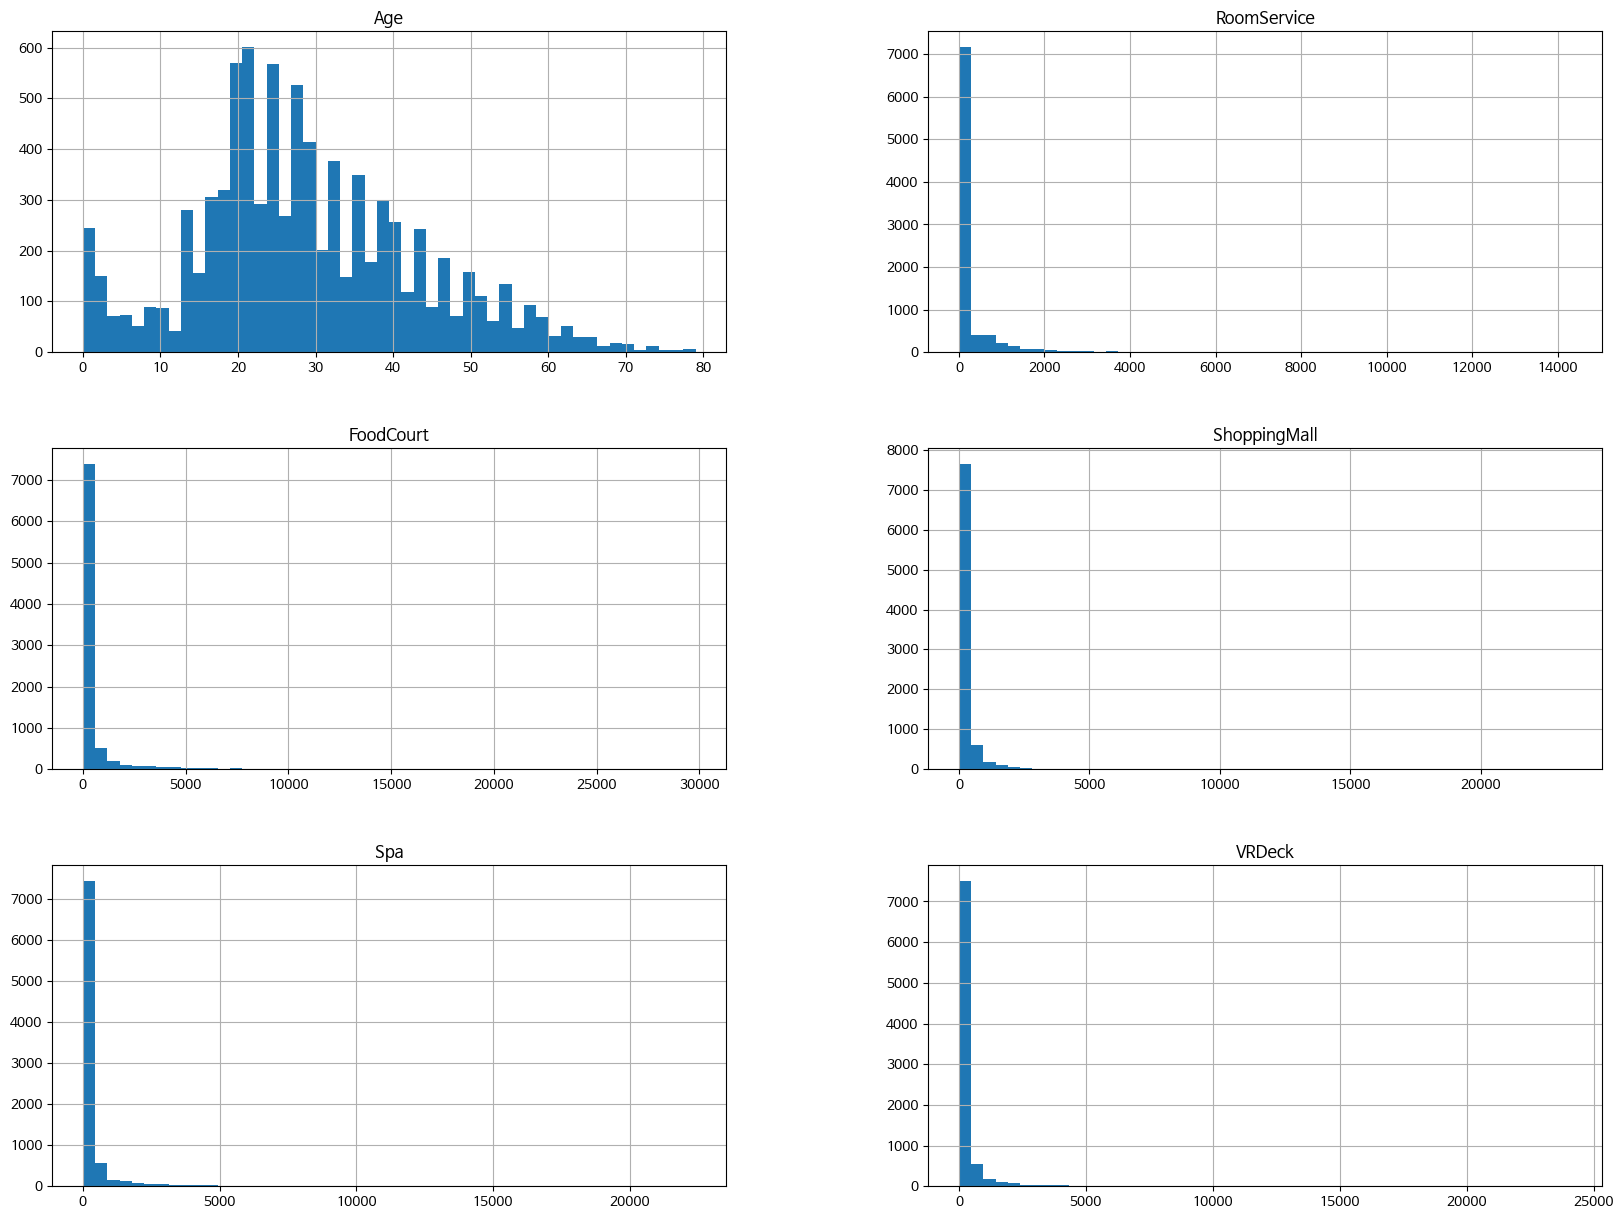

In [ ]:
# 수치형 자료 히스토그램 그려보기
data = data_df[numeric_cols]
data.hist(bins=50, figsize=(20,15))
plt.show()

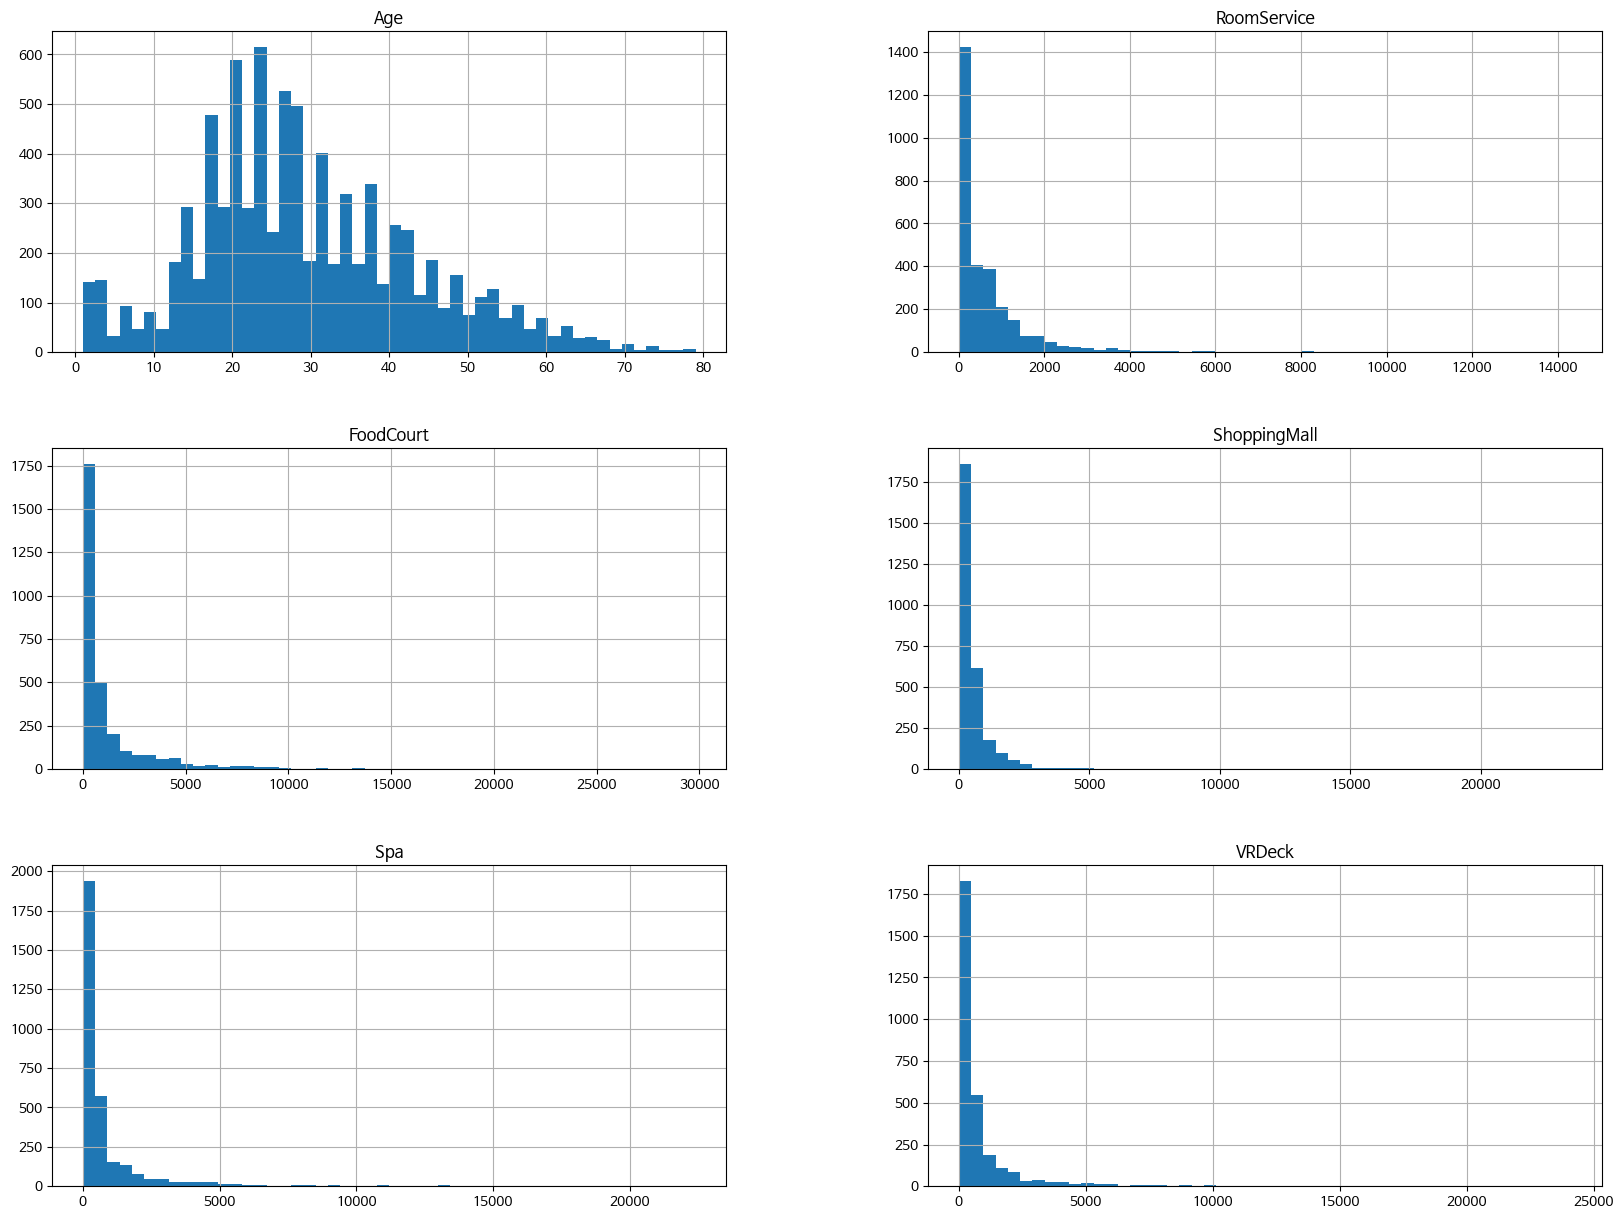

In [ ]:
# 0인 값 빼고 그려보기
data2 = data_df[numeric_cols][data_df[numeric_cols]!=0]
data2.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
# KNN 사용해서 'numeric_cols' 채우기 위해 원본 데이터 가져오기
data_df[numeric_cols] = data_df2[numeric_cols]

In [ ]:
# KNN 사용해서 수치형 자료만 결측값 채우기

from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5)
data = imp.fit_transform(data_df[numeric_cols]) # KNN Imputation for numeric features
# imputation 결과가 np.array라 다시 dataframe으로 만들어줌.
_data_df = pd.DataFrame(data=data, columns=numeric_cols)

# imputation한 column을 그에 맞는 위치의 train data에 overwrite.
for num_col in numeric_cols:
    data_df[num_col] = _data_df[num_col] # overwrite with imputed column.


In [ ]:
# 다양한 방법으로 feature 전처리
# CatBoost용 데이터 => df_temp

data_df3 = pd.read_csv('./titanic.csv')

# 비용 지불 5개 항목의 결측치를 0으로 입력

data_df3.RoomService.fillna(0, inplace=True)
data_df3.FoodCourt.fillna(0, inplace=True)
data_df3.ShoppingMall.fillna(0, inplace=True)
data_df3.Spa.fillna(0, inplace=True)
data_df3.VRDeck.fillna(0, inplace=True)

data_df3['sum_5'] = data_df3[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
data_df3[['Deck', 'Num', 'Side']] = data_df3['Cabin'].str.split('/', expand=True)

numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# KNN 사용해서 수치형 자료만 결측값 채우기

from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5)
data = imp.fit_transform(data_df3[numeric_cols]) # KNN Imputation for numeric features
# imputation 결과가 np.array라 다시 dataframe으로 만들어줌.
_data_df = pd.DataFrame(data=data, columns=numeric_cols)

# imputation한 column을 그에 맞는 위치의 train data에 overwrite.
for num_col in numeric_cols:
    data_df[num_col] = _data_df[num_col] # overwrite with imputed column.

df_temp = data_df.copy()

# 결측치 최빈값으로 채우기
df_temp.HomePlanet.fillna(df_temp.HomePlanet.mode()[0], inplace=True)
df_temp.Cabin.fillna(df_temp.Cabin.mode()[0], inplace=True)
df_temp.Destination.fillna(df_temp.Destination.mode()[0], inplace=True)
df_temp.VIP.fillna(df_temp.VIP.mode()[0], inplace=True)
df_temp.Deck.fillna(df_temp.Deck.mode()[0], inplace=True)
df_temp.Num.fillna(df_temp.Num.mode()[0], inplace=True)
df_temp.Side.fillna(df_temp.Side.mode()[0], inplace=True)

print(df_temp.Deck.isna().sum())
print(df_temp.Side.isna().sum())
print(df_temp.Num.isna().sum())

# 열 삭제
df_temp.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# 원핫벡터로 만들기
df_temp = pd.get_dummies(df_temp, columns=['HomePlanet'])
df_temp = pd.get_dummies(df_temp, columns=['CryoSleep'])
df_temp = pd.get_dummies(df_temp, columns=['Destination'])
df_temp = pd.get_dummies(df_temp, columns=['VIP'])
df_temp = pd.get_dummies(df_temp, columns=['Deck'])
df_temp = pd.get_dummies(df_temp, columns=['Side'])

# True, False 값을 모두 0과 1로 변환
df_temp = df_temp.astype(int)
df_temp.info()

0
0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Age                        8693 non-null   int64
 1   RoomService                8693 non-null   int64
 2   FoodCourt                  8693 non-null   int64
 3   ShoppingMall               8693 non-null   int64
 4   Spa                        8693 non-null   int64
 5   VRDeck                     8693 non-null   int64
 6   Transported                8693 non-null   int64
 7   Num                        8693 non-null   int64
 8   sum_5                      8693 non-null   int64
 9   HomePlanet_Earth           8693 non-null   int64
 10  HomePlanet_Europa          8693 non-null   int64
 11  HomePlanet_Mars            8693 non-null   int64
 12  CryoSleep_False            8693 non-null   int64
 13  CryoSleep_True             8693 non-null   int64
 14  Destination_55 Can

In [ ]:
# 'AgeGroup' 열 추가
# 전처리 완료
data_df['AgeGroup'] = pd.cut(data_df['Age'],right=False, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80], \
                                                            labels=[0, 10, 20, 30, 40, 50, 60, 70])
data_df.AgeGroup.value_counts().sort_index()
data_df.AgeGroup

0       30
1       20
2       50
3       30
4       10
        ..
8688    40
8689    10
8690    20
8691    30
8692    40
Name: AgeGroup, Length: 8693, dtype: category
Categories (8, int64): [0 < 10 < 20 < 30 < 40 < 50 < 60 < 70]

<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [ ]:
# categorical, numeric, drop features 구분하기
# X_data, y_Dataa 선언
y_data = data_df[['Transported']]

del data_df['Transported']
X_data = data_df.copy()

# 다양한 조합으로 feature 그룹을 바꿔가면 찾아보기
drop_features = ["PassengerId", "Cabin", "Name", "Num", "sum_5"]
numeric_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'AgeGroup']
X_data = X_data.drop(drop_features, axis =1)

In [ ]:
# train_test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(6085, 13)
(6085, 1)
(2608, 13)
(2608, 1)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6085 entries, 7289 to 2732
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   HomePlanet    6085 non-null   object  
 1   CryoSleep     6085 non-null   object  
 2   Destination   6085 non-null   object  
 3   Age           6085 non-null   float64 
 4   VIP           6085 non-null   bool    
 5   RoomService   6085 non-null   float64 
 6   FoodCourt     6085 non-null   float64 
 7   ShoppingMall  6085 non-null   float64 
 8   Spa           6085 non-null   float64 
 9   VRDeck        6085 non-null   float64 
 10  Deck          6085 non-null   object  
 11  Side          6085 non-null   object  
 12  AgeGroup      6085 non-null   category
dtypes: bool(1), category(1), float64(6), object(5)
memory usage: 582.7+ KB


In [ ]:
X_train.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age              117
VIP                2
RoomService     1052
FoodCourt       1167
ShoppingMall     916
Spa             1056
VRDeck          1048
Deck               9
Side               3
AgeGroup           8
dtype: int64

In [ ]:
# features 그룹 별 인코딩 진행
# categorical - OneHotEncoder, numeric - StandardScaler

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore')
# 전부 0으로 채워줌

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
# 파이프라인 생성
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # preprocessing-only

In [ ]:
# X_train fit
preprocessor_pipe.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['HomePlanet', 'CryoSleep',
                                                   'Destination', 'VIP', 'Deck',
                                                   'Side', 'AgeGroup'])]))])

In [ ]:
# transform
X_train_transformed = preprocessor_pipe.transform(X_train)
X_test_transformed = preprocessor_pipe.transform(X_test)


# preprocessor_pipe.transform(X_train).todense()

In [ ]:
# 데이터 확인
print(X_train_transformed.shape)
print(y_train.shape)
print(X_test_transformed.shape)
print(y_test.shape)

# 6개의 numeric variables & 6개의 categorical variables (각각 2,3,9개 & 6개 카테고리)
print(len(X_train_transformed[0]))
X_train_transformed[0]

(6085, 35)
(6085, 1)
(2608, 35)
(2608, 1)
35


array([-0.30315468, -0.11490368,  0.05095212, -0.27232796, -0.07473302,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ])

In [ ]:
pd.DataFrame(X_train_transformed).head(3)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,-0.303155,-0.114904,0.050952,-0.272328,-0.074733,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.330344,-0.285311,-0.233737,-0.272328,0.359801,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.330344,-0.286627,-0.247738,-0.208063,3.530221,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<br>

## 3. Create model instance variable (동시에 여러 모델을 다른 이름으로 만들 수 있습니다.)

In [ ]:
# 하이퍼 파라미터 튜닝 값 지정
# 각 모델 별 원하는 하이퍼 파라미터 값 넣어보기

lgb_grid = {
    # 'num_leaves': [31, 50, 100],
    # 'max_depth': [None, 5, 10],
    # 'learning_rate': [0.1, 0.01, 0.001],
    # 'n_estimators': [100, 200, 500]
}

GradientBoosting_grid = {
    # 'learning_rate': [0.1, 0.01, 0.001],
    # 'n_estimators': [100, 200, 500],
    # 'max_depth': [3, 5, 10],
    # 'subsample': [0.8, 0.9, 1.0],
    # 'min_samples_split': [2, 5, 10]
}

LogisticRegression_grid = {
    # 'penalty': ['l1', 'l2'],
    # 'C': [0.1, 1.0, 10.0],
    # 'solver': ['liblinear', 'lbfgs']
}

xgb_grid = {
    'learning_rate': [0.05], # you can exclude "0.001"
    'n_estimators': [400], # 500, 1000, 1500
    'max_depth': [4],
    'random_state': [0]
}

AdaBoostClassifier_grid = {
    # 'n_estimators': [50, 100, 200],  # 예시 값들
    # 'learning_rate': [0.1, 0.5, 1.0],  # 예시 값들
    # 'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}


RandomForestClassifier_grid = {
    # 'n_estimators': [100, 200, 300],
    # 'max_depth': [None, 5, 10],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
}

In [ ]:
# 하이퍼 파라미터 튜닝

param_grid_list7 = [lgb_grid,
                    GradientBoosting_grid,
                    LogisticRegression_grid,
                    xgb_grid,
                    AdaBoostClassifier_grid,
                    RandomForestClassifier_grid]
model_top7 = [lgb.LGBMClassifier(),
              GradientBoostingClassifier(),
              LogisticRegression(),
              xgb.XGBClassifier(),
              AdaBoostClassifier(),
              RandomForestClassifier(),
              ]
model_list = []
for i in range(len(model_top7)):
  model = GridSearchCV(model_top7[i], param_grid_list7[i],
                           refit=True, cv=5, n_jobs=-1, verbose=1, scoring= 'accuracy')
  model.fit(X_train_transformed, y_train)

  model_list.append(model)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


<br>

## 4. Predict on test data & Check the result with metrics (모델 간 비교가 가능합니다.)

In [ ]:
# accuracy 기준 - 모델 스코어 정리
# classification_report - 모델 스코어 정리

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
for i,model in enumerate(model_list):
  print('model name => ', type(model_top7[i]).__name__)
  model.fit(X_train_transformed, y_train)

  # train_accuracy = accuracy_score(y_train, model.predict(X_train_transformed))
  # test_accuracy = accuracy_score(y_test, model.predict(X_test_transformed))

  train_classification_report = classification_report(y_train, model.predict(X_train_transformed))
  test_classification_report = classification_report(y_test, model.predict(X_test_transformed))

  # print(f'{type(model_top7[i]).__name__} train => accuracy:', train_accuracy)
  # print(f'{type(model_top7[i]).__name__} test => accuracy:', test_accuracy)
  # print('\n')

  print(f'{type(model_top7[i]).__name__} train => classification_report:', train_classification_report)
  print(f'{type(model_top7[i]).__name__} test => classification_report:', test_classification_report)
  print('\n')


model name =>  LGBMClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits
LGBMClassifier train => classification_report:               precision    recall  f1-score   support

       False       0.89      0.84      0.86      3012
        True       0.85      0.90      0.87      3073

    accuracy                           0.87      6085
   macro avg       0.87      0.87      0.87      6085
weighted avg       0.87      0.87      0.87      6085

LGBMClassifier test => classification_report:               precision    recall  f1-score   support

       False       0.83      0.75      0.79      1303
        True       0.77      0.84      0.81      1305

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



model name =>  GradientBoostingClassifier
Fitting 5 folds for each of 1 candidates, totalling 5 fits
GradientBoostingClassifier train => classification_report:   

In [ ]:
# catboost 모델 적용해보기
!pip install catboost

In [ ]:
# catboost 모델 적용해보기 - data_df3 생성 후 feature 튜닝
# 튜닝한 df_temp를 통해 train_test 나누기

X_train, X_test, y_train, y_test = \
    train_test_split(df_temp.drop('Transported', axis=1), df_temp['Transported'], test_size=0.3, random_state=0)

In [ ]:
# catboost 모델 적용해보기

from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=0)  # verbose=0 for silent training
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Accuracy_train: %.2f%%" % (accuracy_train * 100.0))

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy_train: 88.38%
Accuracy: 81.60%


In [ ]:
# xgb의 80보다 cat이 81.6으로 테스트 결과를 기준으로 더 높게 나옴

In [ ]:
# 모델 결과 파일
result = pd.read_excel('./Titanic Spaceship 튜닝_r1.xlsx')
result

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,NaN,Titanic Spaceship 튜닝 (박성현),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,모델,P_Id,HomePlanet\t,CryoSleep,Cabin,Deck,Side,Num,Destination,...,VIP,Sum_5,Room,Food,Shop,Spa,VR,Name,정답률,NaN
3,NaN,XGBoost,삭제,원핫인코딩\n결측:최빈값,원핫인코딩\n결측:금액기준,삭제,NaN,NaN,NaN,원핫인코딩\n결측:최빈값,...,원핫인코딩\n결측:최빈값,추가열\n스케일링,삭제,삭제,삭제,삭제,삭제,삭제,0.7366,Age는 원본데이터를 그대로 쓰는게 낫다
4,NaN,XGBoost,삭제,원핫인코딩\n결측:최빈값,원핫인코딩\n결측:금액기준,삭제,NaN,NaN,NaN,원핫인코딩\n결측:최빈값,...,원핫인코딩\n결측:최빈값,추가열\n스케일링,삭제,삭제,삭제,삭제,삭제,삭제,0.7362,NaN
5,NaN,XGBoost,삭제,원핫인코딩\n결측:최빈값,원핫인코딩\n결측:금액기준,삭제,NaN,NaN,NaN,원핫인코딩\n결측:최빈값,...,원핫인코딩\n결측:최빈값,추가열\n스케일링,삭제,삭제,삭제,삭제,삭제,삭제,0.7339,NaN
6,NaN,XGBoost,삭제,원핫인코딩\n결측:최빈값,원핫인코딩\n결측:금액기준,삭제,NaN,NaN,NaN,원핫인코딩\n결측:최빈값,...,원핫인코딩\n결측:최빈값,추가열\n스케일링,삭제,삭제,삭제,삭제,삭제,삭제,0.732,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,XGBoost,삭제,"원핫인코딩\n결측:1,2,3순위로",원핫인코딩\n결측:최빈값,삭제,NaN,NaN,NaN,원핫인코딩\n결측:최빈값,...,원핫인코딩\n결측:최빈값,추가열\n스케일링,삭제,삭제,삭제,삭제,삭제,삭제,0.7327,HomePlanet 결측치는 최빈값 처리가 낫다
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
